<hr />
<em>LTAT.06.011 – Fundamentals of Autonomous Driving</em>

## Motion prediction (Naive methods)


 In this Lab, we will explore some very naive approaches to predict motion of a target object. Tasks are orientated in a way that the difficulty of accessing the prediction problem increases as we progress forward. The crux here is to understand how naive prediction models perform well on simple scenarios but their performance deterioates as scene complexity increases.


#### Deliverable for the lab exercise:

You will submit the same `jupyter-notebook` file. Please note that you don't need to submit the `helper.py` <b>unless</b> you do any modifications there which is not recommended. You are required to fill the missing code snippets. Additionally, each section requires your brief answer about what you understood.
Submit the deliverable(s) through Moodle. Late policy is the same as earlier. For a delay of each day beyond the submission deadline, there is a `10%` penalty on the total marks. In other words, if you are late by one day, the score is capped at `90%` of the total marks. And if you are late by `10` days, no marks can be awarded for the lab exercise.


For queries write to: mahir.gulzar@ut.ee
<hr />



### Please answer following after you finish your assignment

<span style="color:Red">Question: </span>  How much time did it take for you to complete the assignment?

<span style="color:Green">Answer: </span>

</br>
</br>
</br>




### Getting started

<em> Imports </em>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper import generate_linear_trajectory, generate_curved_trajectory, generate_circle_trajectory

We learned from the lecture that the motion of an object is usually modelled in the form trajectory. In following tasks you will be given a ground-turth trajectory. You are required to write a simple motion predicion method that takes in half ground-truth trajectoy and estimates `n` future steps using history of the ground-truth. Please read the code comments carefully while writing your solution.

<hr />


### Task-1: Linear trajectory: 
In this task we will model a linear trajectory using constant velocity model.

<hr />

<em> Run code section below, it should display an example linear trajectory </em>

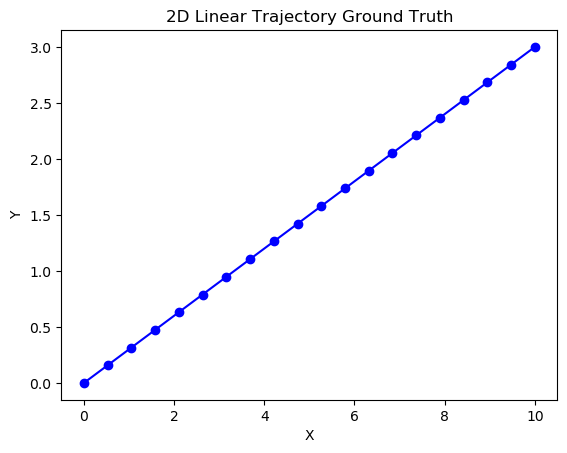

In [2]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D linear trajectory.
linear_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


# Plot the trajectory
x_vals = [p[0] for p in linear_trajectory_ground_truth]
y_vals = [p[1] for p in linear_trajectory_ground_truth]
plt.plot(x_vals, y_vals, 'bo-')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Linear Trajectory Ground Truth')
plt.show()

<em> Write a function `predict_trajectory` that takes in 2D trajectory and predicts next `n` number of future trajectory points using simple constant velocity model. The function should return complete trajectory i.e. the output size of the predicted trajectory should be `input_points + n_future_points`  You can assume fixed time delta `dt=0.1`</em>

In [3]:
####################################
###### YOUR CODE STARTS HERE #######
####################################

def predict_trajectory(trajectory, n, use_acceleration=True):
    dt=0.1

    # Calculate the velocity vector from the trajectory
    velocity = np.diff(trajectory, axis=0) / dt
    
    if use_acceleration:
        # Calculate the acceleration vector from the velocity vector
        acceleration = np.diff(velocity, axis=0) / dt
        
        # Assume the acceleration remains constant and extrapolate the next n points
        for i in range(n):
            last_point = trajectory[-1]
            last_velocity = velocity[-1]
            last_acceleration = acceleration[-1]
            next_point = last_point + last_velocity*dt + 0.5*last_acceleration*dt**2
            trajectory = np.vstack((trajectory, next_point))
            velocity = np.vstack((velocity, last_velocity + last_acceleration*dt))
            acceleration = np.vstack((acceleration, last_acceleration))
    
    else:
        # Assume constant velocity and extrapolate the next n points
        for i in range(n):
            last_point = trajectory[-1]
            last_velocity = velocity[-1]
            next_point = last_point + last_velocity*dt
            trajectory = np.vstack((trajectory, next_point))
            velocity = np.vstack((velocity, last_velocity))
    
    return trajectory


#################################
###### YOUR CODE ENDS HERE ######
#################################

<em> Call the `predict_trajectory` method you wrote above with required arguments</em>

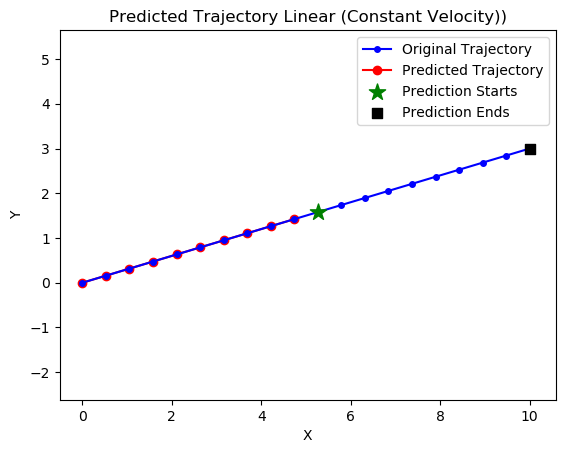

In [4]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D linear trajectory.
linear_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(linear_trajectory_ground_truth)/2)

####################################
###### YOUR CODE STARTS HERE #######
####################################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = linear_trajectory_ground_truth[:half_len]
# predicted_trajectory = predict_trajectory(linear_trajectory_ground_truth[:half_len], n, use_acceleration=False)


#################################
###### YOUR CODE ENDS HERE ######
#################################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(linear_trajectory_ground_truth[:, 0], linear_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(linear_trajectory_ground_truth[half_len][0], linear_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(linear_trajectory_ground_truth[-1][0], linear_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Linear (Constant Velocity))')
ax.legend()
plt.show()

<span style="color:Red">Question: </span> Describe what you see. Also explain with your own understanding for which types of object types will this model work? When should it fail?
<br>

<span style="color:Green">Answer: </span>

<hr />


### Task-2: Curved trajectory: 
Similar to previous task, in this task we will try to model motion of an object which is moving in a curved path.

<hr />

<em> Run code section below, it should display an example curved trajectory </em>

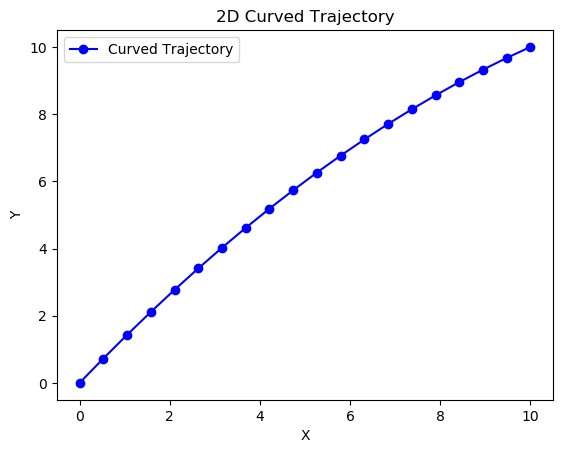

In [5]:
# Define the starting and ending points and number of points
start_point = (0, 0)
end_point = (10, 10)
num_points = 20

# Generate the curved trajectory
trajectory = generate_curved_trajectory(start_point, end_point, num_points)

# Plot the trajectory
fig, ax = plt.subplots()
ax.plot(trajectory[:, 0], trajectory[:, 1], 'bo-', label='Curved Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Curved Trajectory')
ax.legend()
plt.show()


<em> Call the `predict_trajectory` method you wrote above with required arguments</em>

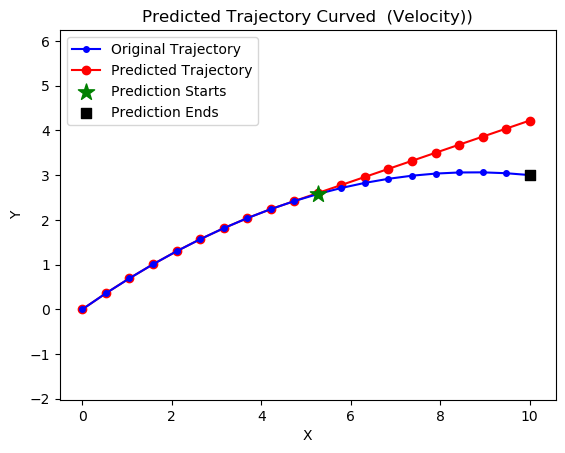

In [6]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_curved_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

####################################
###### YOUR CODE STARTS HERE #######
####################################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, use_acceleration=False)


#################################
###### YOUR CODE ENDS HERE ######
#################################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(curved_trajectory_ground_truth[-1][0], curved_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved  (Velocity))')
ax.legend()
plt.show()


<span style="color:Red">Question: </span> Describe what you see. Why the motion model failed here? Did you thought of this failure while you were answering the linear case? 
<br>

<span style="color:Green">Answer: </span>

<em> Lets modify the `predict_trajectory` method so that in addition to velocity we also make use of acceleration. What you need to do is to add a keyword parameter `use_acceleration` to the function which by default should be `false`. Depending on the function call you can toggle the use acceleration in the prediction functionality.</em>

In [7]:
####################################
###### YOUR CODE STARTS HERE #######
####################################

# Write the updated predit_trajectory function here OR update it where you wrote it above

#################################
###### YOUR CODE ENDS HERE ######
#################################


<em> Call the updated `predict_trajectory` method with `use_acceleration=True` </em>

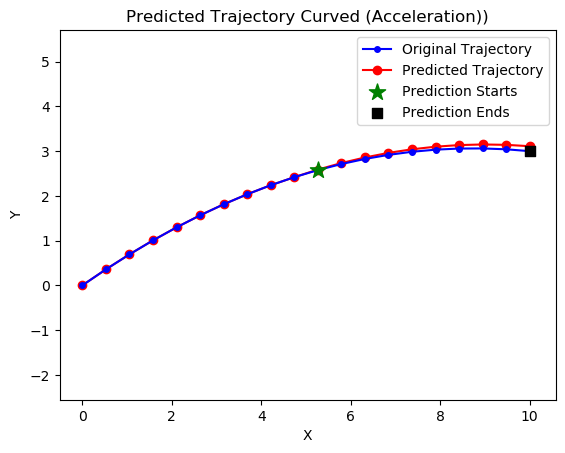

In [8]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_curved_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

####################################
###### YOUR CODE STARTS HERE #######
####################################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, use_acceleration=True)


#################################
###### YOUR CODE ENDS HERE ######
#################################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(curved_trajectory_ground_truth[-1][0], curved_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved (Acceleration))')
ax.legend()
plt.show()

<span style="color:Red">Question: </span> Describe what you see. From your understanding, If we add more derivatives in motion model, would we gain more better results, Would it even make sense if we add derivative of acceleration a.k.a [Jerk](https://en.wikipedia.org/wiki/Jerk_(physics))?
<br>

<span style="color:Green">Answer: </span>

<hr />


### Task-3: Circular trajectory: 
Lets test our updated `predict_trajectory` for an object which is moving in circle.

<hr />

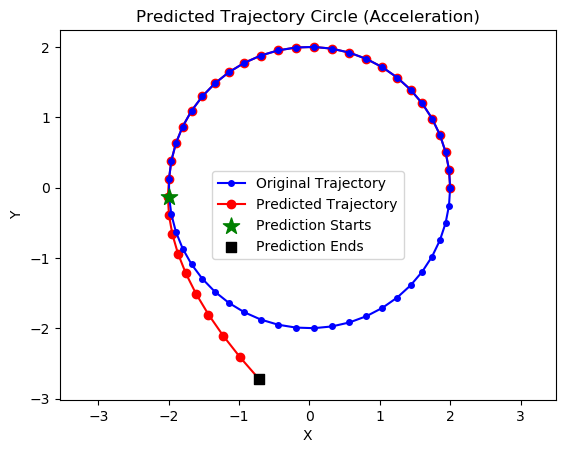

In [9]:
# Define the center of the circle, radius, and number of points
center = (0, 0)
radius = 2
num_points = 50

# Generate the circular trajectory
circular_trajectory = generate_circle_trajectory(center, radius, num_points)

# Define the time step and number of points to predict
n = 10
half_len = int(len(circular_trajectory)/2)


####################################
###### YOUR CODE STARTS HERE #######
####################################


# Comment this line and call the updated predict_trajectory method with use_acceleration=True for circular trajectory
predicted_trajectory = circular_trajectory[:half_len]

# # Predict the next n points of the trajectory without acceleration
predicted_trajectory = predict_trajectory(circular_trajectory[:half_len], n, use_acceleration=True)

#################################
###### YOUR CODE ENDS HERE ######
#################################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(circular_trajectory[:, 0], circular_trajectory[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(circular_trajectory[half_len][0], circular_trajectory[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(predicted_trajectory[-1][0], predicted_trajectory[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Circle (Acceleration)')
ax.legend()
plt.show()



<span style="color:Red">Question: </span> Describe what you see. 
<br>

<span style="color:Green">Answer: </span>

<span style="color:Yellow">Question: (Optional): </span> In general, how would a model know that the object is moving in circular path, any suggestions?

<span style="color:Green">Answer: </span>

<hr />


### Task-4: Noisy measurements
Previously, we were relying on smooth trajectories as ground-truth but real world data is noisy. The past trajectory given to the prediction model can have both longitudinal and lateral noise. In this task, you are required to re-run `one` experiment (choose any) which you performed previously but this time you should add noise both along x and y axis of the ground-truth trajectory. You can copy code snippets from previous sections.

<hr />

<em> Get a ground truth trajectory, add some measurement noise along both x & y axis, call the predict_trajectory method and visualize the results</em>

In [10]:
####################################
###### YOUR CODE STARTS HERE #######
####################################




#################################
###### YOUR CODE ENDS HERE ######
#################################

<span style="color:Red">Question: </span> Describe your experiment results. Did the model handle noisy data well?
<br>

<span style="color:Green">Answer: </span>

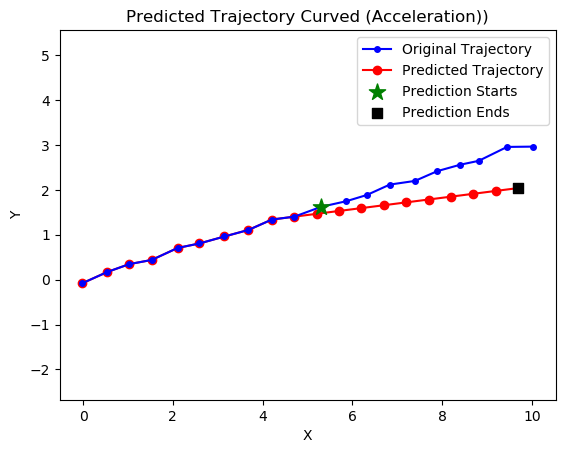

In [11]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


measurement_noise = 0.06
curved_trajectory_ground_truth = curved_trajectory_ground_truth + np.random.randn(len(curved_trajectory_ground_truth), 2) * measurement_noise

# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

###################################
###### YOUR CODE STARTS HERE ######
###################################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, use_acceleration=False)


#################################
###### YOUR CODE ENDS HERE ######
#################################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(predicted_trajectory[-1][0], predicted_trajectory[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved (Acceleration))')
ax.legend()
plt.show()

<hr />


### Task-5: Filter based predictions
In previous lectures, we studied Kalman Filters, which helped us with noisy measurements in localization. In modular pipeline, you will quite often find these filters in localization and tracking module of the stack. When we track an obstacle, what we are usually doing under the hood is updating state-estimates of that obstacle using associated detections as measurement updates to the filter.

In this task, we will use a Kalman filter to predict future `n` steps of the obstacle. For the update step we will use noisy measurement instead of the ground-truth. You don't need to write the filter yourself, it is already given to you in `helpers.py`. Take a look at the parameters and methods of KalmanFilter class.

<hr />

In the section below. You are required to fill the missing code block. Following are steps you need to perform to complete this task.

1. Create a new array `trajectory_measurement` which will be noisy version of original trajectory see variable `original_trajectory`.

2. Instantiate an object of KalmanFilter class. The constructor takes in first measurement and boolean telling the filter to toggle between velocity or acceleration model.

3. Iterate over `trajectory_measurement` array, in each iteration call `predict()` and `update()`. <span style="color:Red">NOTE: </span>.   The measurement updates to the filter should stop after half length of the trajectory (see variable `half_len` ). 

4. During iteration, if `half_len` is crossed then your code should only call `predict()` function and only run `n` more iterations afterwards. 

5. During each iteration you will collect the latest state of the filter by calling the `get_state()[0:2]`. This will give you latest positional estimate of the filter. The positional estimates should be collected in numpy array called `filter_predicted_trajectory`.


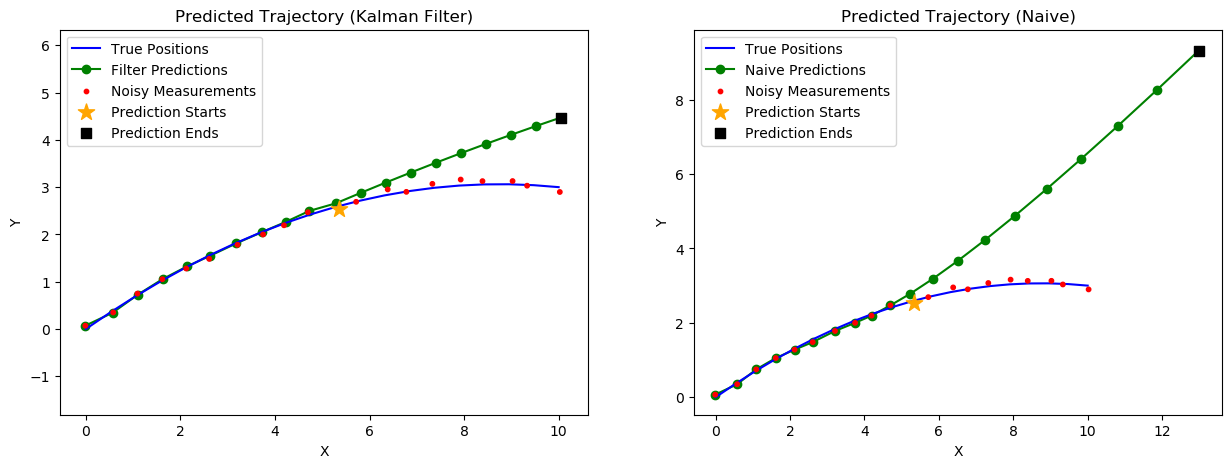

In [12]:
from helper import KalmanFilter


# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

original_trajectory = generate_curved_trajectory(start_point, end_point, num_points)


n = 10
measurement_noise = 0.06
half_len = int((len(trajectory)/2))

###################################
###### YOUR CODE STARTS HERE ######
###################################

trajectory_measurement = original_trajectory + np.random.randn(len(original_trajectory), 2) * measurement_noise

kf = KalmanFilter([trajectory_measurement[0][0], trajectory_measurement[0][1]], use_acceleration=True)

filter_predicted_trajectory = []
prediction_counter = 0
for i in range(len(trajectory_measurement)):
    kf.predict()

    if(i <= half_len):
        kf.update(trajectory_measurement[i])
        filter_predicted_trajectory.append(kf.get_state()[0:2])

    else:
        if prediction_counter < n:
            prediction_counter += 1
            filter_predicted_trajectory.append(kf.get_state()[0:2])
        else:
            break

filter_predicted_trajectory = np.array(filter_predicted_trajectory)


naive_predicted_trajectory = predict_trajectory(trajectory_measurement[:half_len], n, use_acceleration=True)

#################################
###### YOUR CODE ENDS HERE ######
#################################


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(original_trajectory[:, 0], original_trajectory[:, 1], 'b-', label='True Positions',  zorder=2)
ax1.scatter(trajectory_measurement[:,0], trajectory_measurement[:,1], label='Noisy Measurements',s=[10]*(len(trajectory_measurement)), color='r', zorder=3)
ax1.plot(filter_predicted_trajectory[:,0], filter_predicted_trajectory[:,1], 'bo-', label='Filter Predictions', color='g',  zorder=1)
ax1.scatter(trajectory_measurement[half_len][0], trajectory_measurement[half_len][1], label='Prediction Starts', marker='*', color='orange', s=[150],  zorder=3)
ax1.scatter(filter_predicted_trajectory[-1:,0], filter_predicted_trajectory[-1:,1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax1.axis('equal')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Predicted Trajectory (Kalman Filter)')
ax1.legend()

ax2.plot(original_trajectory[:, 0], original_trajectory[:, 1], 'b-', label='True Positions',  zorder=2)
ax2.scatter(trajectory_measurement[:,0], trajectory_measurement[:,1], label='Noisy Measurements',s=[10]*(len(trajectory_measurement)), color='r', zorder=3)
ax2.plot(naive_predicted_trajectory[:,0], naive_predicted_trajectory[:,1], 'bo-', label='Naive Predictions', color='green',  zorder=1)
ax2.scatter(trajectory_measurement[half_len][0], trajectory_measurement[half_len][1], label='Prediction Starts', marker='*', color='orange', s=[150],  zorder=3)
ax2.scatter(naive_predicted_trajectory[-1:,0], naive_predicted_trajectory[-1:,1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax2.axis('equal')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Predicted Trajectory (Naive)')
ax2.legend()



<span style="color:Red">Question: </span> Compare results of both prediction models. (For better understanding run the above code block multiple times)
<br>

<span style="color:Green">Answer: </span>